# 加载数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sb
plt.rcParams['figure.figsize']=(12.0,10.0)

In [3]:
types={'StateHoliday': np.dtype(str)}
train=pd.read_csv('data/train.csv',parse_dates=[2],nrows=66901,dtype=types)
store=pd.read_csv('data/store.csv')

## 数据探索

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
#确认关门的店都没有销量

not_open=train[(train['Open']==0)&(train['Sales']!=0)]
print(str(not_open.size==0))

True


In [6]:
#确认开门的店都有销量

not_sales=train[(train['Open']!=0)&(train['Sales']==0)]
print(str(not_sales.size==0))

True


In [7]:
train=train.loc[train['Sales']>0]

In [8]:
assert(train[train['Sales']==0].size==0)

In [9]:
dates=pd.to_datetime(train['Date'],format='%Y%m%d:%H:%M:%S.%f').sort_values()

In [10]:
dates=dates.unique()
start_date=dates[0]
end_date=dates[-1]

date_range=pd.date_range(start_date,end_date).values
assert(all(dates==date_range))

In [11]:
print('起始日期：',start_date)
print('结束日期：',end_date)

起始日期： 2015-06-01T00:00:00.000000000
结束日期： 2015-07-31T00:00:00.000000000


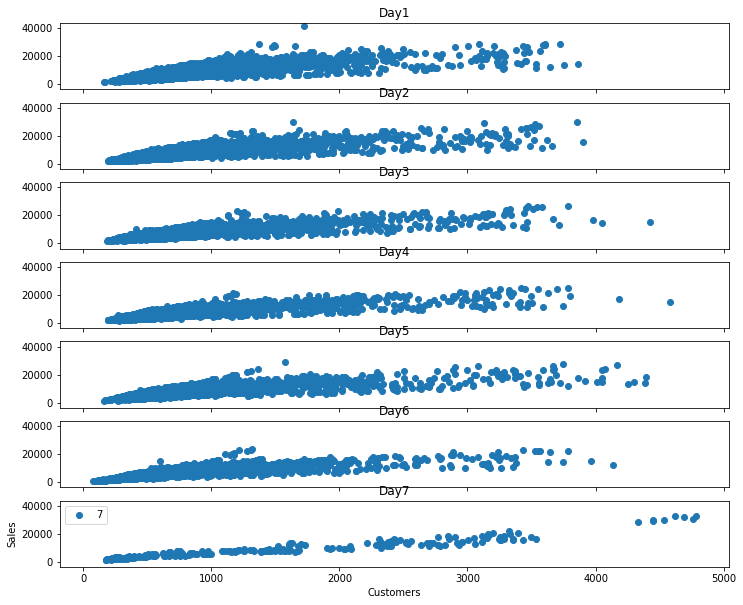

In [16]:
plt.rcParams['figure.figsize']=(12.0,10.0)
f,ax = plt.subplots (7,sharex=True,sharey=True)
for i in range(1,8):
    mask=train[train['DayOfWeek']==i]
    ax[i-1].set_title('Day{0}'.format(i))
    ax[i-1].scatter(mask['Customers'],mask['Sales'],label=i)
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

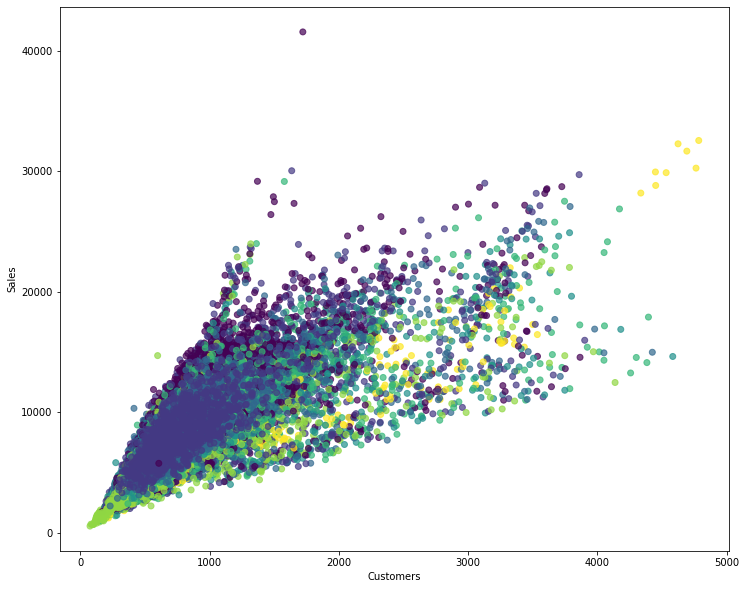

In [17]:
plt.rcParams['figure.figsize']=(12.0,10.0)
plt.scatter(train['Customers'],train['Sales'],c=train['DayOfWeek'],alpha=0.7)
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

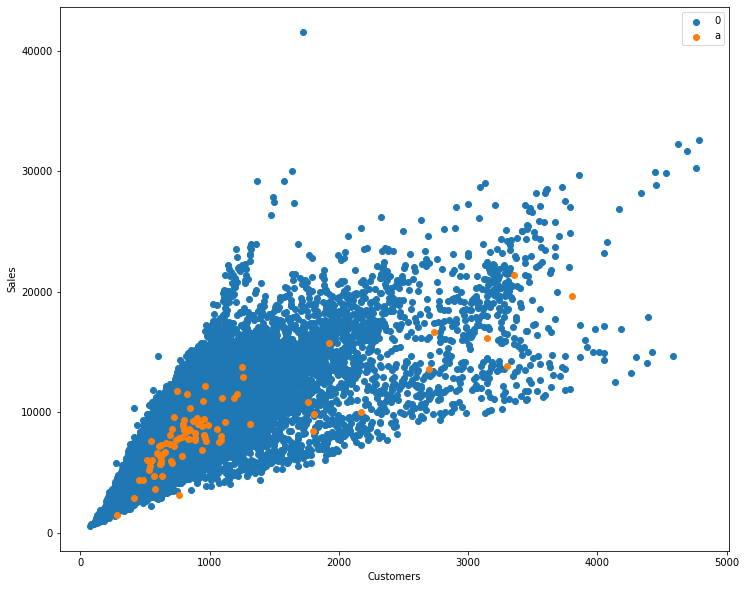

In [18]:
plt.rcParams['figure.figsize']=(12.0,10.0)
for i in ['0','a','b','c']:
    data=train[train['StateHoliday']==i]
    if len(data)==0:
        continue
    plt.scatter(data['Customers'],data['Sales'],label=i)
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

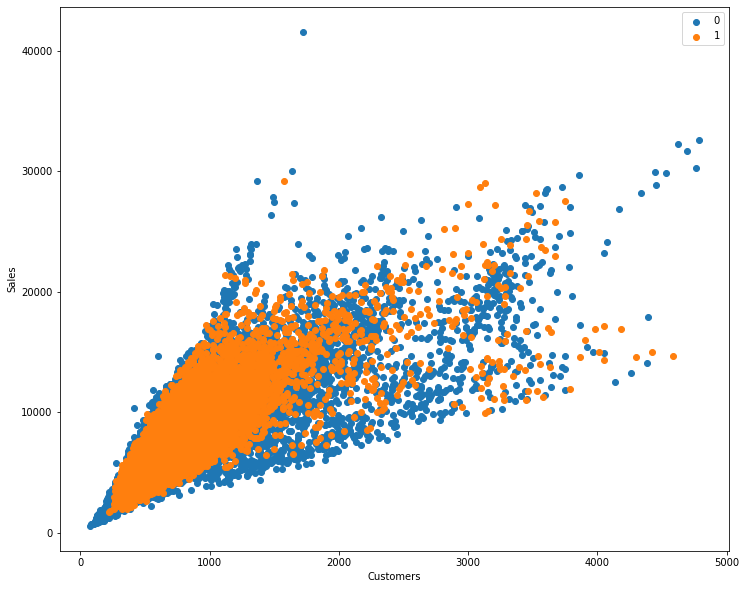

In [19]:
for i in [0,1]:
    data=train[train['SchoolHoliday']==i]
    if(len(data)==0):
        continue
    plt.scatter(data['Customers'],data['Sales'],label=i)
    
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

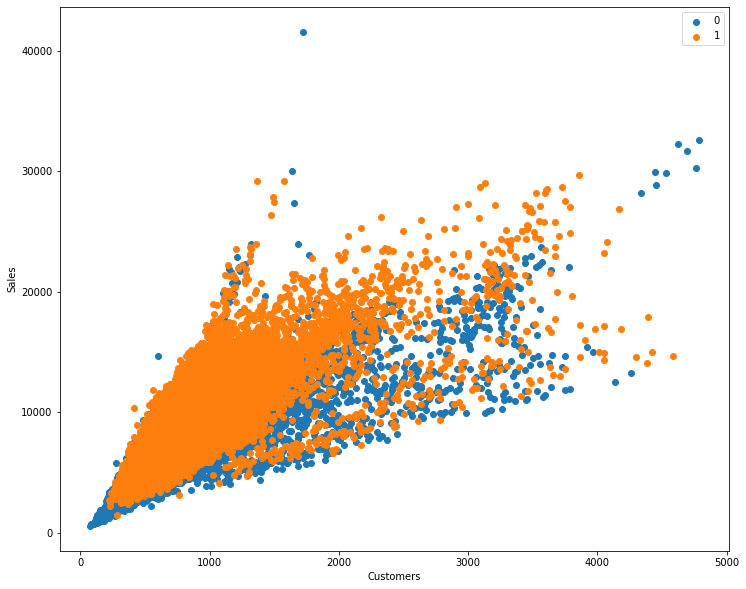

In [20]:
for i in [0,1]:
    data=train[train['Promo']==i]
    if(len(data)==0):
        continue
    plt.scatter(data['Customers'],data['Sales'],label=i)
    
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [21]:
#然后来探究一下商店


In [22]:
train['SalesPerCustomer']=train['Sales']/train['Customers']

avg_store=train.groupby('Store')[['Sales','Customers','SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x:'Avg'+x,inplace=True)
store=pd.merge(avg_store.reset_index(),store,on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4447.634615,510.211538,8.670743,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4998.769231,596.557692,8.459276,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7095.274510,716.843137,9.785061,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9843.288462,1271.461538,7.702043,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4612.211538,522.980769,8.764831,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


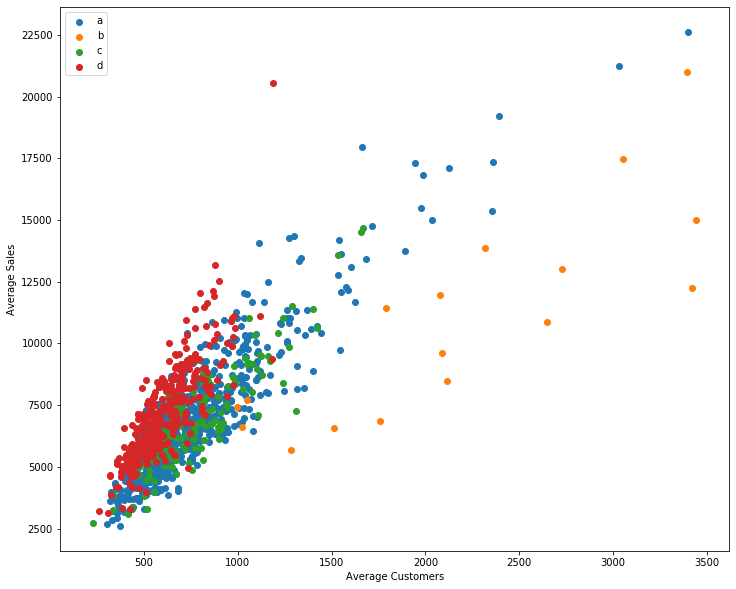

In [23]:
for i in ['a','b','c','d']:
    data=store[store['StoreType']==i]
    if (len(data)==0):
        continue
    plt.scatter(data['AvgCustomers'],data['AvgSales'],label=i)
    
plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

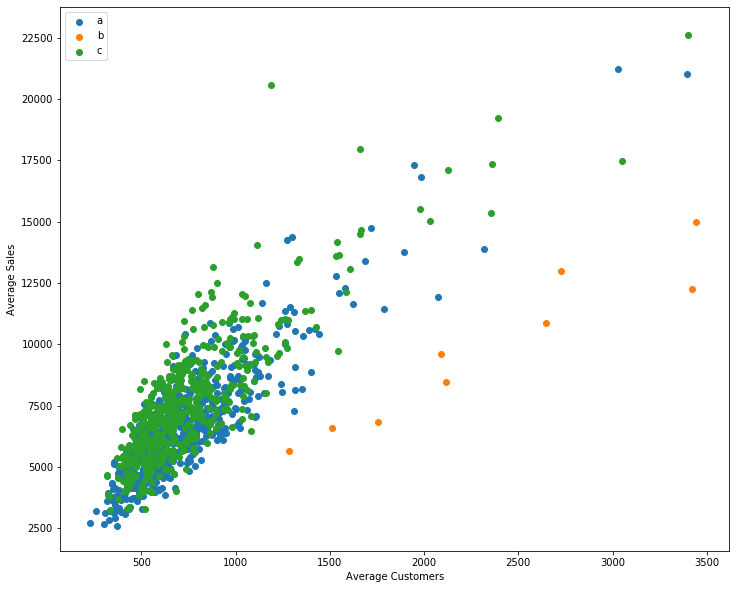

In [25]:
for i in ['a','b','c']:
    data=store[store['Assortment']==i]
    if (len(data)==0):
        continue
    plt.scatter(data['AvgCustomers'],data['AvgSales'],label=i)
    
plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

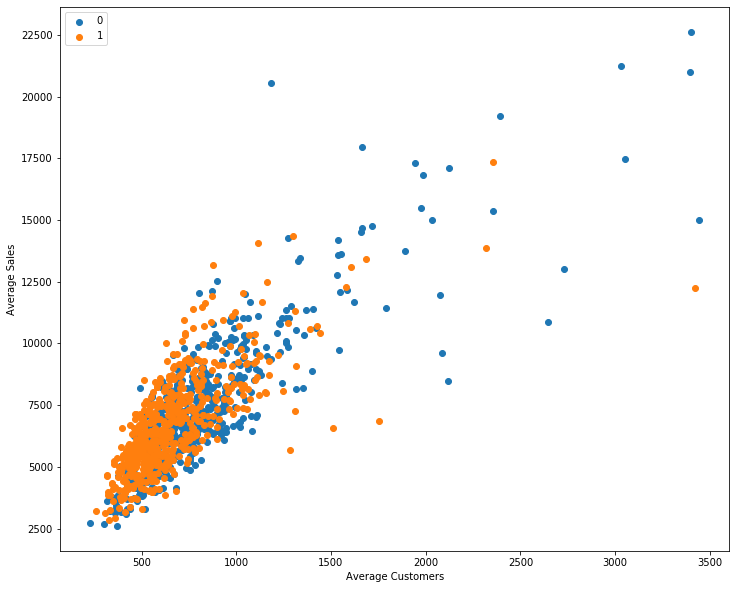

In [26]:
for i in [0,1]:
    data=store[store['Promo2']==i]
    if (len(data)==0):
        continue
    plt.scatter(data['AvgCustomers'],data['AvgSales'],label=i)
    
plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

## 特征工程与模型构建

In [40]:
def build_features(train,store):
    store['StoreType']=store['StoreType'].astype('category').cat.codes
    store['Assortment']=store['Assortment'].astype('category').cat.codes
    train['StateHoliday']=train['StateHoliday'].astype('category').cat.codes
    merged=pd.merge(train,store,on='Store',how='left')
    NaN_replace=0
    merged.fillna(NaN_replace,inplace=True)
    merged['Year']=merged.Date.dt.year
    merged['Month']=merged.Date.dt.month
    merged['Day']=merged.Date.dt.day
    merged['Week']=merged.Date.dt.week
    
    merged['MonthsCompetitionOpen']= 12*(merged['Year']-merged['CompetitionOpenSinceYear'])+(merged['Month']-merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear']==NaN_replace, 'MonthsCompititonOpen']=NaN_replace,
    
    merged['WeeksPromoOpen']= 12*(merged['Year']-merged['Promo2SinceYear'])+(merged['Date'].dt.weekofyear-merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear']==NaN_replace, 'WeeksPromoOpen']=NaN_replace,
    
    toInt=[
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'MonthsCompetitionOpen',
        'WeeksPromoOpen'
    ]
    merged[toInt]=merged[toInt].astype(int)
    return merged
    

In [48]:

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,MonthsCompititonOpen,WeeksPromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,...,0,0,0,2015,7,31,31,82,NaN,0
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400,...,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,31,92,NaN,78
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,...,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,31,103,NaN,65
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457,...,0,0,0,2015,7,31,31,70,NaN,0
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118,...,0,0,0,2015,7,31,31,3,NaN,0


In [49]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
#    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [65]:
def rmspe(y,y_hat):
    return np.sqrt(np.mean(((y-y_hat)/y)**2))

rmspe_score=make_scorer(rmspe,greater_is_better=False)

def score(model,x_train,y_train,y_test,y_hat):
    score=cross_val_score(model,x_train,y_train,scoring=rmspe_score,cv=5)
    print('mean:',score.mean())
    print('variance',score.var())
    print('rmspe',rmspe(y_test,y_hat))
    
def plot_importance(model):
    k=list(zip(X,model.feature_importances_))
    k.sort(key=lambda tup:tup[1])
    labels,vals=zip(*k)
    plt.barh(np.arange(len(X)),vals,align='center')
    plt.yticks(np.arange(len(X)),labels)

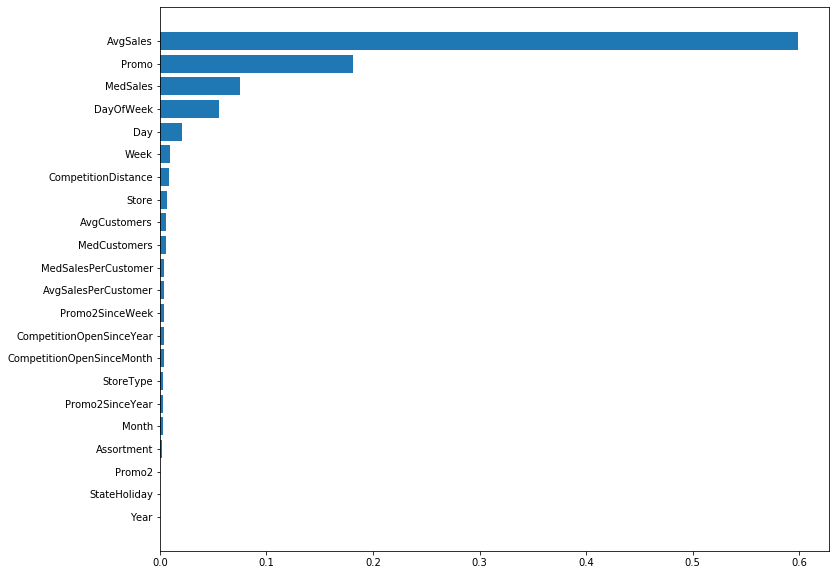

In [66]:
from sklearn.tree import DecisionTreeRegressor
decision_tree=DecisionTreeRegressor()
decision_tree.fit(X_train,y_train)
plot_importance(decision_tree)

In [67]:
y_hat=decision_tree.predict(X_test)
score(decision_tree,X_train,y_train,y_test,y_hat)

mean: -0.14780641842544742
variance 2.7329646529982826e-05
rmspe 0.14201798333973792


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.9s finished


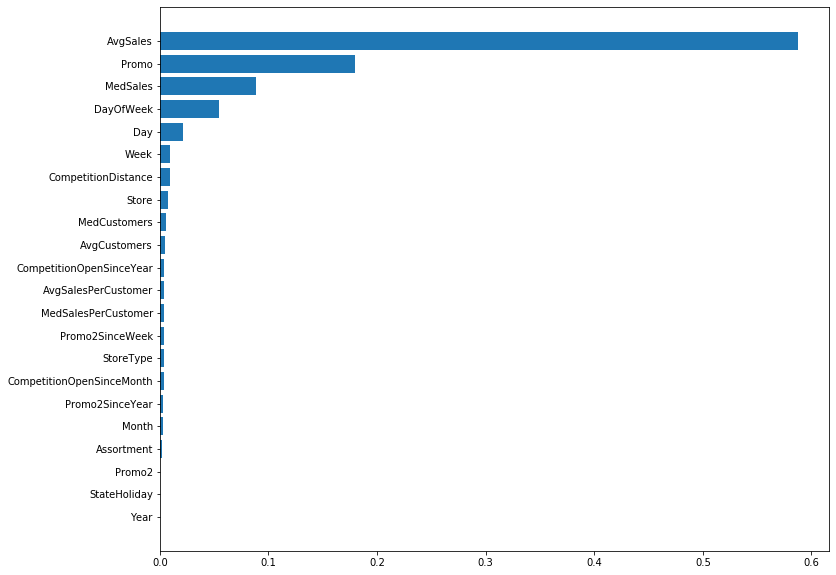

In [68]:
from sklearn.ensemble import RandomForestRegressor
randomForest=RandomForestRegressor(n_estimators=25,n_jobs=-1,verbose=1)
randomForest.fit(X_train,y_train)
plot_importance(randomForest)

In [69]:
y_hat=randomForest.predict(X_test)
score(randomForest,X_train,y_train,y_test,y_hat)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  2

mean: -0.11076874414953194
variance 3.8539299190026695e-05
rmspe 0.10438865212920168


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished


In [70]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 2000,
    eta = 0.1,
    max_depth = 6,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_alpha = 0.05,
    silent = 1,
    random_state = 2020
)
xgboost_tree.fit(X_train[X], np.log1p(y_train), 
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 50,
                 verbose = 30
                )

[0]	validation_0-rmse:7.46374	validation_1-rmse:7.46942	validation_0-rmspe:0.999543	validation_1-rmspe:0.999545
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 50 rounds.


/Users/xiaonaozhong/anaconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[30]	validation_0-rmse:0.345473	validation_1-rmse:0.34762	validation_0-rmspe:0.286658	validation_1-rmspe:0.287429
[60]	validation_0-rmse:0.122287	validation_1-rmse:0.128741	validation_0-rmspe:0.129384	validation_1-rmspe:0.13393
[90]	validation_0-rmse:0.115696	validation_1-rmse:0.123561	validation_0-rmspe:0.123856	validation_1-rmspe:0.130035
[120]	validation_0-rmse:0.109839	validation_1-rmse:0.119165	validation_0-rmspe:0.11577	validation_1-rmspe:0.124316
[150]	validation_0-rmse:0.104801	validation_1-rmse:0.115235	validation_0-rmspe:0.10956	validation_1-rmspe:0.119603
[180]	validation_0-rmse:0.101295	validation_1-rmse:0.112936	validation_0-rmspe:0.105099	validation_1-rmspe:0.116777
[210]	validation_0-rmse:0.097721	validation_1-rmse:0.110536	validation_0-rmspe:0.100919	validation_1-rmspe:0.113705
[240]	validation_0-rmse:0.094516	validation_1-rmse:0.108301	validation_0-rmspe:0.097339	validation_1-rmspe:0.111218
[270]	validation_0-rmse:0.09188	validation_1-rmse:0.106636	validation_0-rmspe:0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=2, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=2020,
             reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=1, subsample=0.8, verbosity=1)

In [71]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

Mean -0.09262541720027191
Variance 1.8009545740868918e-05
RMSPE 0.08903878150908405


In [72]:
test = pd.read_csv("./data/test.csv", parse_dates=["Date"], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('submission.csv', index=False)